<a href="https://colab.research.google.com/github/medalidia/apprentissage_git/blob/main/projet_polarite_avis_clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projet NLP – Classification de la polarité des avis clients
**Auteur : Mohamed Ali Dia**  
**Date : Juillet 2025**  

Ce projet a pour objectif de développer un système automatique permettant de classifier un avis client en ligne comme **positif** ou **négatif**, en utilisant un jeu de données d’avis en français.  
Nous allons passer par les étapes suivantes :

- Prétraitement des textes (nettoyage, lemmatisation)
- Analyse exploratoire
- Vectorisation des textes (TF-IDF)
- Entraînement de plusieurs modèles de classification
- Évaluation comparative
- Sauvegarde des modèles


## 1. Importation des bibliothèques

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import joblib
import spacy
from wordcloud import WordCloud
from collections import Counter
import itertools

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score
)


## 2. Préparation des outils linguistiques

In [9]:

nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

# Chargement du modèle SpaCy français avec gestion d’erreur
import subprocess
try:
    nlp = spacy.load("fr_core_news_sm")
except:
    subprocess.run(["python", "-m", "spacy", "download", "fr_core_news_sm"])
    nlp = spacy.load("fr_core_news_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Chargement du jeu de données

In [10]:
splits = {'train': 'allocine/train-00000-of-00001.parquet', 'validation': 'allocine/validation-00000-of-00001.parquet', 'test': 'allocine/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/tblard/allocine/" + splits["train"])
from datasets import load_dataset


# Réduire à un échantillon pour limiter le temps d'exécution
df = df.sample(10000, random_state=42)

# Garder uniquement les colonnes utiles
df = df[['review', 'label']]

# Affichage des premières lignes
print(df.head())

                                                   review  label
120476  Un excellent thriller d'action où les scènes d...      1
32693   Si le scénariste, qui aurait pu faire un minim...      0
79958   Référence dans la filmographie de Bogart, "Le ...      0
76366   Un bon scénario, un bon film, une histoire lou...      1
82343   Un scenario vide et une mise en scene trés sop...      0


## 4. Nettoyage et lemmatisation des textes

In [11]:

def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc
              if token.lemma_.lower() not in stop_words and token.is_alpha and len(token) > 2]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_and_lemmatize)
df[['review', 'clean_review']].head()


,review,clean_review
120476,Un excellent thriller d'action où les scènes d...,excellent thriller daction scène bravoure croi...
32693,"Si le scénariste, qui aurait pu faire un minim...",scénariste avoir faire minimum recherche évite...
79958,"Référence dans la filmographie de Bogart, ""Le ...",référence filmographie bogart violent nen rest...
76366,"Un bon scénario, un bon film, une histoire lou...",bon scénario bon film histoire loufoque ténébr...
82343,Un scenario vide et une mise en scene trés sop...,scenario vide mise scene trer soporifique fill...


## 5. Exploration des données (répartition des classes)

label
1    5096
0    4904
Name: count, dtype: int64


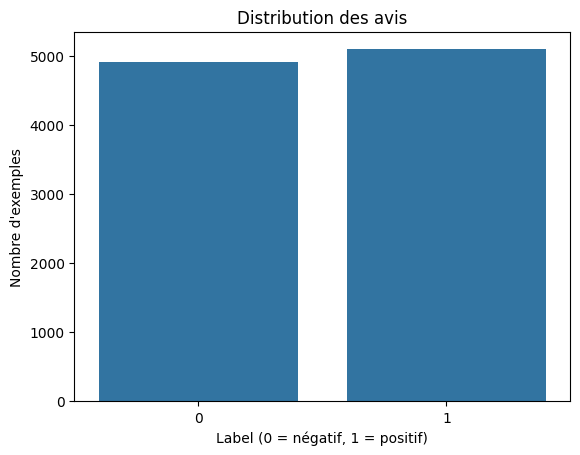

In [12]:

print(df['label'].value_counts())

sns.countplot(x='label', data=df)
plt.title("Distribution des avis")
plt.xlabel("Label (0 = négatif, 1 = positif)")
plt.ylabel("Nombre d'exemples")
plt.show()


## 6. Visualisation des mots les plus fréquents

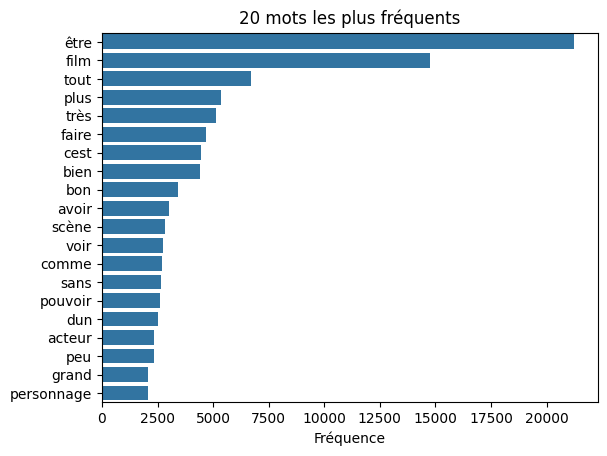

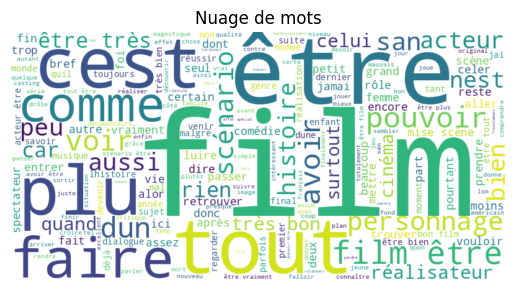

In [13]:

all_words = list(itertools.chain(*df['clean_review'].str.split()))
word_freq = Counter(all_words).most_common(20)
words, counts = zip(*word_freq)

sns.barplot(x=counts, y=words)
plt.title("20 mots les plus fréquents")
plt.xlabel("Fréquence")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots")
plt.show()


## 7. Vectorisation des textes (TF-IDF)

In [14]:

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_review'])
y = df['label']


## 8. Séparation des données d'entraînement et de test

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 9. Entraînement des modèles de classification

In [16]:

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


## 10. Évaluation des modèles

=== Régression Logistique ===
[[865 110]
 [104 921]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       975
           1       0.89      0.90      0.90      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.893


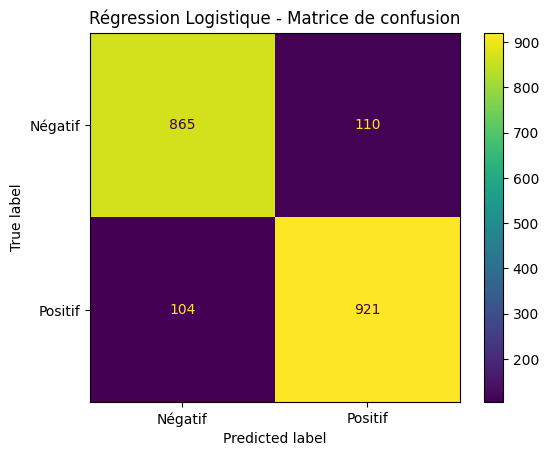

=== SVM Linéaire ===
[[862 113]
 [110 915]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       975
           1       0.89      0.89      0.89      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.8885


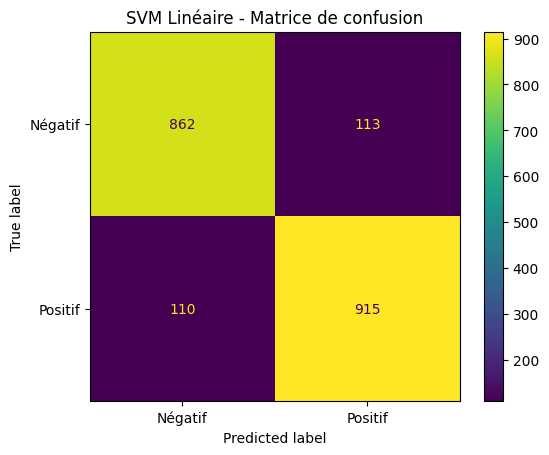

=== Random Forest ===
[[841 134]
 [167 858]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       975
           1       0.86      0.84      0.85      1025

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Accuracy: 0.8495


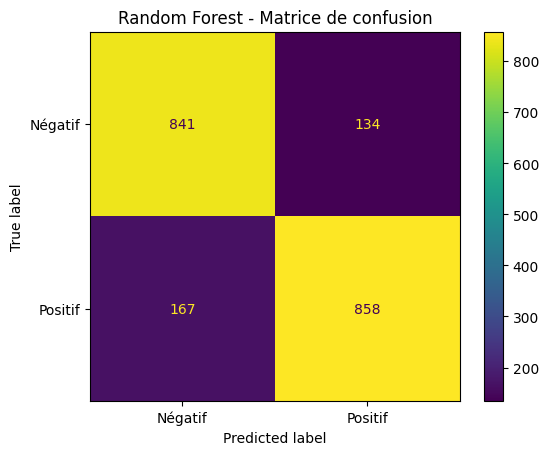

In [17]:

def eval_model(name, y_true, y_pred):
    print(f"=== {name} ===")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Négatif", "Positif"])
    plt.title(f"{name} - Matrice de confusion")
    plt.show()

eval_model("Régression Logistique", y_test, y_pred_lr)
eval_model("SVM Linéaire", y_test, y_pred_svm)
eval_model("Random Forest", y_test, y_pred_rf)


### 🔍 F1-score pondéré (complément d'évaluation)

In [18]:

print("F1-score pondéré - Logistic Regression :", f1_score(y_test, y_pred_lr, average="weighted"))
print("F1-score pondéré - SVM :", f1_score(y_test, y_pred_svm, average="weighted"))
print("F1-score pondéré - Random Forest :", f1_score(y_test, y_pred_rf, average="weighted"))


F1-score pondéré - Logistic Regression : 0.8929910049478792
F1-score pondéré - SVM : 0.888495564760353
F1-score pondéré - Random Forest : 0.849521109150136


## 11. Comparaison des performances des modèles

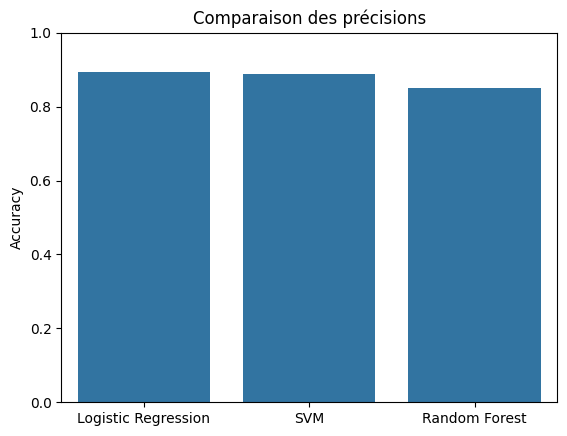

In [19]:

models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf)
]

sns.barplot(x=models, y=accuracies)
plt.title("Comparaison des précisions")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


## 12. Échantillon de prédictions

In [20]:

indices = y_test.iloc[:5].index
sample_preds = pd.DataFrame({
    "Review": df.loc[indices, 'review'].values,
    "Label réel": y_test.loc[indices].values,
    "Prédiction LR": y_pred_lr[:5],
    "Prédiction SVM": y_pred_svm[:5],
    "Prédiction RF": y_pred_rf[:5]
})
sample_preds


,Review,Label réel,Prédiction LR,Prédiction SVM,Prédiction RF
0,l'idée de la possession ou du dédoublement de ...,0,0,0,0
1,"Très bonne comédie dramatique, coécrite et scé...",1,1,1,1
2,Même si l'on sent un véritable engagement de P...,0,0,0,0
3,"Son premier film, un court métrage, il l'a réa...",0,0,0,0
4,On sait en allant voir ce film qu'on ne pourra...,0,0,0,0


## 13. Sauvegarde des modèles entraînés

In [21]:

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(lr_model, "logistic_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_lr.fit(df['clean_review'], df['label'])
joblib.dump(pipeline_lr, "pipeline_logistic.pkl")

print("Tous les modèles ont été sauvegardés avec succès.")


Tous les modèles ont été sauvegardés avec succès.
